<a href="https://colab.research.google.com/github/santiagobgb/Bendfords-Laws/blob/main/SportsViu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip uninstall -y tensorflow
!pip install tensorflow opencv-python matplotlib


Found existing installation: tensorflow 2.15.0
Uninstalling tensorflow-2.15.0:
  Successfully uninstalled tensorflow-2.15.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.1 MB/s eta 0:00:00


In [2]:
import cv2
import tensorflow as tf
import numpy as np
from IPython.display import display, Image
import time
from google.colab.patches import cv2_imshow
import cv2
import tensorflow_hub as hub
from matplotlib import pyplot as plt
import numpy as np
from google.colab.patches import cv2_imshow
from collections import deque
import os
import subprocess
import shutil

In [3]:
model = hub.load('https://tfhub.dev/google/movenet/multipose/lightning/1')
movenet = model.signatures['serving_default']

In [4]:
def loop_through_people(frame, keypoints, edges, confidence_threshold):
    y, x, c = frame.shape
    for person_keypoints in keypoints:
        person_keypoints = person_keypoints.reshape((17, 3))  # Reshape to the correct format

        for kp in person_keypoints:
            ky, kx, kp_conf = kp[:3]  # Only take the first three values for each keypoint
            if kp_conf > confidence_threshold:
                cv2.circle(frame, (int(kx * x), int(ky * y)), 6, (0, 255, 0), -1)

    draw_connections(frame, keypoints, edges, confidence_threshold)


In [5]:
# Function to draw keypoints on the frame
def draw_keypoints(frame, keypoints, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.multiply(keypoints.reshape((-1, 3)), [y, x, 1])

    for kp in shaped:
        ky, kx, kp_conf = kp[:3]
        if kp_conf > confidence_threshold:
            cv2.circle(frame, (int(kx), int(ky)), 6, (0, 255, 0), -1)


In [6]:
EDGES = {
    (0, 1): (255, 0, 0),  # Red
    (0, 2): (0, 255, 255),  # Cyan
    (1, 3): (255, 0, 0),  # Red
    (2, 4): (0, 255, 255),  # Cyan
    (0, 5): (255, 0, 0),  # Red
    (0, 6): (0, 255, 255),  # Cyan
    (5, 7): (255, 0, 0),  # Red
    (7, 9): (255, 0, 0),  # Red
    (6, 8): (0, 255, 255),  # Cyan
    (8, 10): (0, 255, 255),  # Cyan
    (5, 6): (255, 255, 0),  # Yellow
    (5, 11): (255, 0, 0),  # Red
    (6, 12): (0, 255, 255),  # Cyan
    (11, 12): (255, 255, 0),  # Yellow
    (11, 13): (255, 0, 0),  # Red
    (13, 15): (255, 0, 0),  # Red
    (12, 14): (0, 255, 255),  # Cyan
    (14, 16): (0, 255, 255)  # Cyan
}


In [7]:
def draw_keypoints(frame, keypoints, confidence_threshold):
    y, x, c = frame.shape

    # Assuming the structure of each person's keypoints is [x1, y1, s1, x2, y2, s2, ..., x17, y17, s17]
    for person_keypoints in keypoints[0]:
        person_keypoints = person_keypoints.reshape((17, 3))

        for i in range(0, 56, 3):
            kx, ky, kp_conf = person_keypoints[:, i:i+3].T

            valid_keypoints = kp_conf > confidence_threshold
            valid_keypoints_indices = np.where(valid_keypoints)[0]

            for idx in valid_keypoints_indices:
                cv2.circle(frame, (int(kx[idx] * x), int(ky[idx] * y)), 6, (0, 255, 0), -1)


In [8]:
def draw_connections(frame, keypoints, edges, confidence_threshold):
    """
    Draw connections between keypoints on the frame.

    Args:
    - frame: The input frame.
    - keypoints: Detected keypoints with their confidence scores.
    - edges: A dictionary defining the connections between keypoints.
    - confidence_threshold: Minimum confidence score to consider for drawing connections.
    """
    h, w, _ = frame.shape

    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = keypoints[0, p1]
        y2, x2, c2 = keypoints[0, p2]

        if c1 > confidence_threshold and c2 > confidence_threshold:
            # Convert color values to integers
            color = (int(color[0]), int(color[1]), int(color[2]))

            cv2.line(frame, (int(x1 * w), int(y1 * h)), (int(x2 * w), int(y2 * h)), color, 2)
            cv2.circle(frame, (int(x1 * w), int(y1 * h)), 5, color, -1)
            cv2.circle(frame, (int(x2 * w), int(y2 * h)), 5, color, -1)


In [9]:
# Function to save highlight video using ffmpeg
def save_highlight_video(frames, output_path):
    # Write frames to temporary directory
    temp_dir = '/content/temp_frames/'
    if not os.path.exists(temp_dir):
        os.makedirs(temp_dir)
    for i, frame in enumerate(frames):
        cv2.imwrite(os.path.join(temp_dir, f"frame_{i}.png"), frame.copy())

    # Use ffmpeg to create video
    cmd = f"ffmpeg -framerate 25 -i {temp_dir}/frame_%d.png -c:v libx264 -r 30 -pix_fmt yuv420p {output_path}"
    subprocess.call(cmd, shell=True)

    # Clean up temporary frames
    shutil.rmtree(temp_dir)


In [54]:
def collect_right_hip_positions(person_keypoints, confidence_threshold, right_hip_positions):
    person_keypoints = person_keypoints.reshape((17, 3))  # Assuming COCO model format
    right_hip = person_keypoints[12]  # Index 12 for right hip
    rh_confidence = right_hip[2]

    if rh_confidence > confidence_threshold:
        # Only add position if confidence is high enough
        right_hip_positions.append(right_hip[:2])  # Append (x, y) of the right hip


In [55]:
# Placeholder for frames
frames = []

# Counter for frames where the hand is raised
hand_raised_frames = 0

# Number of frames to consider for hand raising (adjust as needed)
hand_raise_threshold = 2

#hip position
right_hip_positions = []

# Initialize VideoCapture
cap = cv2.VideoCapture('/content/sample_data/IMG_8477.MP4')

# Initialize an empty title
current_title = 'NO SENAL'

# Boolean variable to track if the hand is currently raised
hand_raised = False

# Initialize counters for frames when nose is higher than wrist
nose_higher_frames = 0

# Variable to keep track of frames processed
frame_count = 0

# Buffer to store the last 10 frames
frame_buffer = deque(maxlen=10)

# Initialize the model
model = hub.load('https://tfhub.dev/google/movenet/multipose/lightning/1')
movenet = model.signatures['serving_default']

while cap.isOpened():
    ret, frame = cap.read()

    if not ret:
        break  # Break the loop if no frame is read

    # Append frame to the buffer
    frame_buffer.append(frame.copy())

    # Process every 8rd frame
    if frame_count % 8 == 0:
        # Resize image with the requested size
        img = frame.copy()
        img = tf.image.resize_with_pad(tf.expand_dims(img, axis=0), 384, 640)
        input_img = tf.cast(img, dtype=tf.int32)

        # Detection section
        results = movenet(input_img)

        # Get the raw keypoints_with_scores array
        keypoints_with_scores_raw = results['output_0'].numpy()[:, :, :51].reshape((6, 17, 3))

        # Render keypoints
        loop_through_people(frame, keypoints_with_scores_raw, EDGES, 0.37)


        for person_keypoints in keypoints_with_scores_raw:
            collect_right_hip_positions(person_keypoints, 0.37, right_hip_positions)



        # Logic to track hand raising
        nose_y = keypoints_with_scores_raw[0,0,0]  # Extract y-coordinate of the nose (node 0)
        wrist_y = keypoints_with_scores_raw[0,10,0]  # Extract y-coordinate of the right wrist (node 10)

        if nose_y > wrist_y:
            nose_higher_frames += 1
            if nose_higher_frames > hand_raise_threshold and not hand_raised:
                current_title = 'SENAL'
                hand_raised = True

                # When hand is raised, save the last 10 frames as a highlight video
                highlight_video_path = f"/content/sample_data/highlight_video_{frame_count}.mp4"
                save_highlight_video(list(frame_buffer), highlight_video_path)


        else:
            nose_higher_frames = max(0, nose_higher_frames - 1)
            if hand_raised and nose_higher_frames == 0:
                # Set the title to 'Movenet Multipose' when the hand goes back down
                current_title = 'NO SENAL'
                hand_raised = False

        # Display the current title
        cv2.putText(frame, current_title, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        # Append frame to the list
        frames.append(frame.copy())

    frame_count += 1

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# Remove old frames (if any) before generating new ones
frame_files = [f for f in os.listdir('/content') if f.startswith('frame_')]
for frame_file in frame_files:
    os.remove(os.path.join('/content', frame_file))

# Save frames as images
for i, frame in enumerate(frames):
    cv2.imwrite(f"frame_{i}.png", frame.copy())

# Convert images to video
output_video_path = "/content/sample_data/output_video.mp4"
cmd = f"ffmpeg -framerate 25 -i frame_%d.png -c:v libx264 -r 30 -pix_fmt yuv420p {output_video_path}"
!{cmd}

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

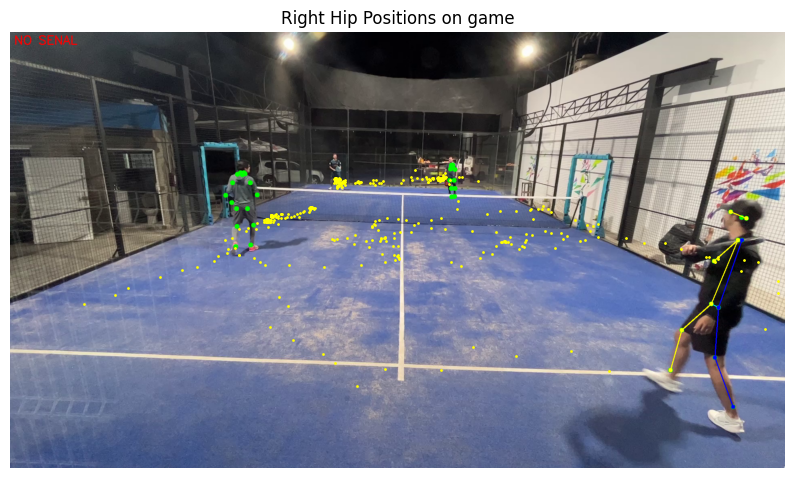

In [72]:
# Assuming right_hip_positions is filled with the normalized (x, y) coordinates
right_hip_positions_array = np.array(right_hip_positions)

# For a 90-degree counterclockwise rotation:
# The new x-coordinates are 1 minus the original y-coordinates
# The new y-coordinates are the original x-coordinates
rotated_x = 1 - right_hip_positions_array[:, 1]  # 1 - original y becomes new x
rotated_y = right_hip_positions_array[:, 0]  # Original x becomes new y

# Now scale the rotated coordinates to the image dimensions
scaled_rotated_x = rotated_x * background_image.shape[1]
scaled_rotated_y = rotated_y * background_image.shape[0]


# Assuming right_hip_positions is filled with the normalized (x, y) coordinates
right_hip_positions_array = np.array(right_hip_positions)

# For a 90-degree counterclockwise rotation:
# The new x-coordinates are 1 minus the original y-coordinates
# The new y-coordinates are the original x-coordinates
rotated_x = 1 - right_hip_positions_array[:, 1]  # 1 - original y becomes new x
rotated_y = right_hip_positions_array[:, 0]  # Original x becomes new y

# Now scale the rotated coordinates to the image dimensions
scaled_rotated_x = rotated_x * background_image.shape[1]
scaled_rotated_y = rotated_y * background_image.shape[0]

# Plot the rotated points on the background image
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(background_image, cv2.COLOR_BGR2RGB))
plt.scatter(scaled_rotated_x, scaled_rotated_y, c='yellow', s=1)  # Use a small dot size
plt.axis('off')
plt.title('Right Hip Positions on game')
plt.show()
